# Neuromatch Academy: Week 2, Day 1, Tutorial 2
# Causal inference with mixture of Gaussians

__Content creators:__ Vincent Valton, Konrad Kording, with help from Matt Krause

__Content reviewers:__ Matt Krause, Jesse Livezey, Karolina Stosio, Saeed Salehi, Michael Waskom

# Tutorial Objectives

The previous notebook introduced Gaussians and Bayes' rule, allowing us to model very simple combinations of auditory and visual input. In this and the following notebook, we will use those building blocks to explore more complicated sensory integration and ventriloquism! 

In this notebook, you will:
1. Learn more about the problem setting, which we wil also use in Tutorial 3,
2. Implement a mixture-of-Gaussian prior, and
3. Explore how that prior produces more complex posteriors.

Video available at https://youtube.com/watch?v=GdIwJWsW9-s


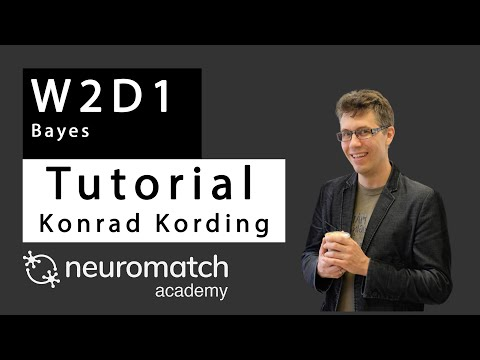

In [1]:
# @title Video 1: Introduction
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='GdIwJWsW9-s', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

# Summary of Video 1:

in
standing experiments in that field we
look at two things that are very
compatible - we have a visual stimulus
somewhere here in a sound that somewhere
close but if we make the difference very
large we get into different domain 

now we will build a Bayesian model for
this case and if we make two things
very different from one another that
they break apart that they're processed
independently so we will both be another
Bayesian why model. 
So we again assume
that vision is near perfect in sets of a
prior belief of where auditory is
but we now assume that it's
not the case that in all cases we expect
the auditor system to be close to the
visual one but we assume that there's
two implied cases 
- there's the common
case where the assumption is that the
visual stimulus must be very close to
the auditor one and 
- then there's an
alternative case the independent case
where we don't believe
two of them to be very close to one
another if anything 

we assume again
that the brain has the objective of
minimizing estimation errors but what
you see is like it's almost the same
model it's just we take one part where
we did a strong simplifying assumption
that the two things always belong
together and now we relax that
assumption 

assume that the vision induced prior
isn't just a Gaussian but it contains
two parts the common cost part which is
the gaussian as we had it before which is
that believe that the auditory is
often should be coming from close to

- want to have the mixture of gaussians
model where we have one - that describes
what happens when they're close to one
another (the standard deviation will be small) t
- not common case or the independent
case where the standard deviation will
be very large; model doesn't implicitly
assume that there's - that the prior
than what that is set up by relation can
have two very different cases either
belongs together and there's a common
cause in there for the priors now
otherwise it's white and both of them
are possible 

- we have a
parameter here P common that tells us
how important one of them is relative to
the other 

We now 
implement to get the combined
prior that has both components


---
##Setup  
Please execute the cells below to initialize the notebook environment.

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#@title Figure Settings
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
#@title Helper functions

def my_gaussian(x_points, mu, sigma):
    """
    DO NOT EDIT THIS FUNCTION !!!

    Returns normalized Gaussian estimated at points `x_points`, with parameters `mu` and `sigma`

    Args:
      x_points (numpy array of floats) - points at which the gaussian is evaluated
      mu (scalar) - mean of the Gaussian
      sigma (scalar) - standard deviation of the gaussian
    Returns:
      (numpy array of floats): normalized Gaussian (i.e. without constant) evaluated at `x`
    """
    px = np.exp(- 1/2/sigma**2 * (mu - x_points) ** 2)

    px = px / px.sum() # this is the normalization part with a very strong assumption, that
                       # x_points cover the big portion of probability mass around the mean.
                       # Please think/discuss when this would be a dangerous assumption.

    return px

def plot_mixture_prior(x, gaussian1, gaussian2, combined):
    """
    DO NOT EDIT THIS FUNCTION !!!

    Plots a prior made of a mixture of gaussians

    Args:
      x (numpy array of floats):         points at which the likelihood has been evaluated
      gaussian1 (numpy array of floats): normalized probabilities for Gaussian 1 evaluated at each `x`
      gaussian2 (numpy array of floats): normalized probabilities for Gaussian 2 evaluated at each `x`
      posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`

    Returns:
      Nothing
    """
    fig, ax = plt.subplots()
    ax.plot(x, gaussian1, '--b', LineWidth=2, label='Gaussian 1')
    ax.plot(x, gaussian2, '-.b', LineWidth=2, label='Gaussian 2')
    ax.plot(x, combined, '-r', LineWidth=2, label='Gaussian Mixture')
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_xlabel('Orientation (Degrees)')


# Discussion of helper functions:

*my_gaussian*:
it returns normalized Gaussian estimated at points `x_points`, with parameters `mu` and `sigma`
we make very strong assumption, that x_points cover the big portion of probability mass around the mean.
When is this a dangerous assumption to make?
In the independent case here or when the x_points are too scattered and not concentrated around the mean!

*plot_mixture_prior*:
Plots a prior made of a mixture of gaussians using:
points at which the likelihood has been evaluated, normalized probabilities for Gaussian 1 evaluated at each `x`, normalized probabilities for Gaussian 2 evaluated at each `x`. normalized probabilities for the posterior evaluated at each `x`


# Section 1: Motivating example

Ventriloquists produce the illusion that their puppets are talking because:
1. We observe the visual input of the puppet moving its mouth, as if speaking.
2. The speech that the puppeteer generates originates near the puppet's mouth. 

Since we are accustomed to voices coming from moving mouths, we tend to interpret the voice as coming directly from the puppet itself rather than from the puppeteer (who is also hiding his/her own mouth movements). In the remaining tutorials, we will study how this illusion breaks down as the distance between the visual stimulus (the puppet's mouth) and the auditory stimulus (the puppeteer's concealed speech) changes. 

Imagine an experiment where participants are shown a puppet moving its mouth at a location directly in front of them (at position 0˚). The subjects are told that 75% of the time, the voice they hear originates from the puppet. On the remaining 25% of trials, sounds come from elsewhere. Participants learn this over multiple trials, after which a curtain is dropped in front of the puppeteer and the puppet. 

Next, we present only the auditory stimulus at varying locations and we ask participants to report where the source of the sound is located. The participants have access to two pieces of information:

*   The prior information about sound localization, learned during the trials before the curtain fell.
*   Their noisy sensory estimates about where a particular sound originates. 

Our eventual goal, which we achieve in Tutorial 3, is to predict the subjects' responses: when do subjects ascribe a sound to the puppet, and when do they believe it originated elsewhere? Doing so requires building a prior that captures the participant's knowledge and expectations, which we will do in the exercises that follow here. 

# Section 2: Mixture-of-Gaussians Prior

In the previous tutorial, you learned how to create a single Gaussian prior that could represent one of these possibilities. A broad Gaussian with a large $\sigma$ could represent sounds originating from nearly anywhere, while a narrow Gaussian with $\mu$ near zero could represent sounds originating from the puppet. 

Here, we will combine those into a mixture-of-Gaussians probability density function (PDF) that captures both possibilities. We will control how the Gaussians are mixed by summing them together with a 'mixing' or weight parameter $p_{common}$, set to a value between 0 and 1, like so:

\begin{eqnarray}
    \text{Mixture} = \bigl[\; p_{common} \times \mathcal{N}(\mu_{common},\sigma_{common}) \; \bigr] + \bigl[ \;\underbrace{(1-p_{common})}_{p_{independent}} \times \mathcal{N}(\mu_{independent},\sigma_{independent}) \; \bigr]
\end{eqnarray}

$p_{common}$ denotes the probability that auditory stimulus shares a "common" source with the learnt visual input; in other words, the probability that the "puppet" is speaking. You might think that we need to include a separate weight for the possibility that sound is "independent" from the puppet. However, since there are only two, mutually-exclusive possibilities, we can replace $p_{independent}$ with $(1 - p_{common})$ since, by the law of total probability, $p_{common} + p_{independent}$ must equal one. 

Using the formula above, complete the code to build this mixture-of-Gaussians PDF: 
* Generate a Gaussian with mean 0 and standard deviation 0.5 to be the 'common' part of the Gaussian mixture prior. (This is already done for you below).
* Generate another Gaussian with mean 0 and standard deviation 3 to serve as the 'independent' part. 
* Combine the two Gaussians to make a new prior by mixing the two Gaussians with mixing parameter $p_{common}$ = 0.75 so that the peakier "common-cause" Gaussian has 75% of the weight. Don't forget to normalize afterwards! 

Hints:
* Code for the `my_gaussian` function from Tutorial 1 is available for you to use. Its documentation is below. 


**Helper function(s)**


In [5]:
help(my_gaussian)

Help on function my_gaussian in module __main__:

my_gaussian(x_points, mu, sigma)
    DO NOT EDIT THIS FUNCTION !!!
    
    Returns normalized Gaussian estimated at points `x_points`, with parameters `mu` and `sigma`
    
    Args:
      x_points (numpy array of floats) - points at which the gaussian is evaluated
      mu (scalar) - mean of the Gaussian
      sigma (scalar) - standard deviation of the gaussian
    Returns:
      (numpy array of floats): normalized Gaussian (i.e. without constant) evaluated at `x`



## Exercise 1: Implement the prior 

In [6]:
def mixture_prior(x, mean=0, sigma_common=0.5, sigma_independent=3, p_common=0.75):

  ###############################################################################
  ## Insert your code here to:
  #   * Create a second gaussian representing the independent-cause component
  #   * Combine the two priors, using the mixing weight p_common. Don't forget
  #      to normalize the result so it remains a proper probability density function
  #
  #   * Comment the line below to test out your function
  raise NotImplementedError("Please complete Exercise 1")
  ###############################################################################

  gaussian_common = my_gaussian(x, mean, sigma_common)
  gaussian_independent = ...
  mixture = ...

  return gaussian_common, gaussian_independent, mixture


x = np.arange(-10, 11, 0.1)

# Uncomment the lines below to visualize out your solution
# common, independent, mixture = mixture_prior(x)
# plot_mixture_prior(x, common, independent, mixture)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


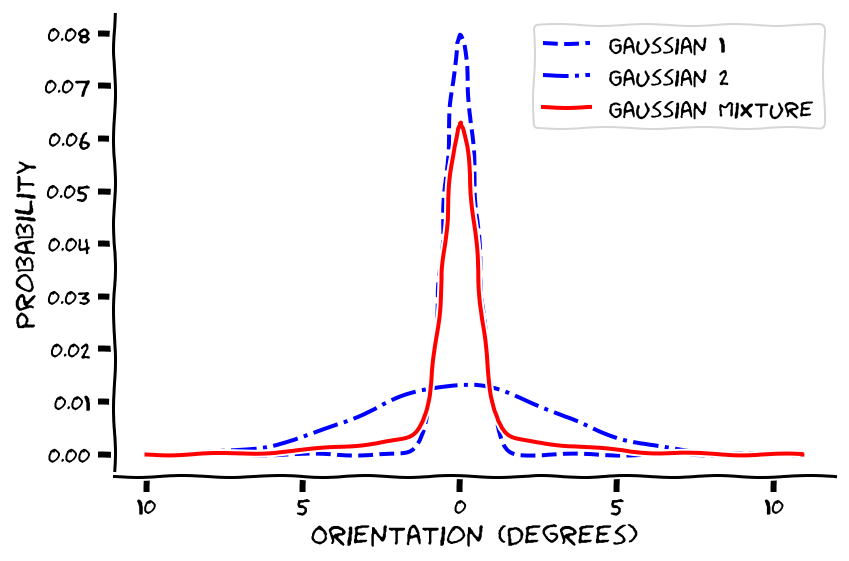

In [7]:
# to_remove solution
def mixture_prior(x, mean=0, sigma_common=0.5, sigma_independent=3, p_common=0.75):

  gaussian_common = my_gaussian(x, mean, sigma_common)
  ###############################################################################
  ## Insert your code here to:
  ##   * Create a second gaussian representing the independent-cause component
  ##   * Combine the two priors, using the mixing weight p_common. Don't forget
  #      to normalize the result so it remains a proper probability density function
  #
  #    * Comment the line below to test out your function
  #raise NotImplementedError("Please complete Exercise 1")
  ###############################################################################
  gaussian_independent = my_gaussian(x, mean, sigma_independent)

  mixture = p_common * gaussian_common + ((1-p_common) * gaussian_independent)
  mixture = mixture / np.sum(mixture)

  return gaussian_common, gaussian_independent, mixture


x = np.arange(-10, 11, 0.1)

# Uncomment the lines below to visualize out your solution
common, independent, mixture = mixture_prior(x)
with plt.xkcd():
  plot_mixture_prior(x, common, independent, mixture)


# Section 3: Bayes Theorem with Complex Posteriors

Video available at https://youtube.com/watch?v=LWKM35te0WI


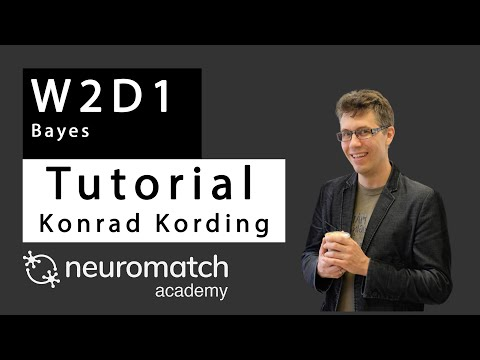

In [8]:
#@title Video 2: Mixture-of-Gaussians and Bayes' Theorem
video = YouTubeVideo(id='LWKM35te0WI', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

# Discussion of Video 2:

- briefly want to emphasize that this is a case of marginalization. 
but the priors, some of the common and the not common model's predictions, and by adding them together
we are effectively considering both possible values of an unknown variable.

Now,
given that we have the prior which now is just slightly different not like it's just the sum of two gaussians,
we can calculate the posterior
using Bayes rule. And this shows you the strength of the Bayesian approach,
we have a completely different prior and yet we can use exactly the same
mechanisms, now like the posterior again is the prior which now is different, times the likelihood and normalize so that it adds up to one.

So, we now want to multiply Gaussians with a mixture of Gaussians,
which just like before is proportional to the prior times the likelihood.

Now, calculate the posterior of this case for the mixture of gaussians or in other words
causal inference model.


Now that we have created a mixture of Gaussians prior that embodies the participants' expectations about sound location, we want to compute the posterior probability, which represents the subjects' beliefs about a specific sound's origin. 

To do so we will compute the posterior by using *Bayes Theorem* to combine the mixture-of-gaussians prior and varying auditory Gaussian likelihood. This works exactly the same as in Tutorial 1: we simply multiply the prior and likelihood pointwise, then normalize the resulting distribution so it sums to 1. (The closed-form solution from Exercise 2B, however, no longer applies to this more complicated prior). 

Here, we provide you with the code mentioned in the video (lucky!). Instead, use the interactive demo to explore how a mixture-of-Gaussians prior and Gaussian likelihood interact. For simplicity, we have fixed the prior mean to be zero. We also recommend starting with same other prior parameters used in Exercise 1: $\sigma_{common} = 0.5, \sigma_{independent} = 3, p_{common}=0.75$; vary the likelihood instead. 

Unlike the demo in Tutorial 1, you should see several qualitatively different effects on the posterior, depending on the relative position and width of likelihood. Pay special attention to both the overall shape of the posterior and the location of the peak. What do you see?

## Interactive Demo 1: Mixture-of-Gaussian prior and the posterior

In [9]:
#@title
#@markdown Make sure you execute this cell to enable the widget!

fig_domain = np.arange(-10, 11, 0.1)
import ipywidgets as widgets

def refresh(sigma_common=0.5, sigma_independent=3, p_common=0.75, mu_auditory=3, sigma_auditory=1.5):
    _, _, prior = mixture_prior(fig_domain, 0, sigma_common, sigma_independent, p_common)
    likelihood = my_gaussian(fig_domain, mu_auditory, sigma_auditory)

    posterior = prior * likelihood
    posterior /= posterior.sum()

    plt.plot(fig_domain, prior, label="Mixture Prior")
    plt.plot(fig_domain, likelihood, label="Likelihood")
    plt.plot(fig_domain, posterior, label="Posterior")

    plt.legend()

    plt.show()

style = {'description_width': 'initial'}

_ = widgets.interact(refresh,
    sigma_common=widgets.FloatSlider(value=0.5, min=0.01, max=10, step=0.5, description="sigma_common", style=style),
    sigma_independent=widgets.FloatSlider(value=3, min=0.01, max=10, step=0.5, description="sigma_independent:", style=style),
    p_common=widgets.FloatSlider(value=0.75, min=0, max=1, steps=0.01, description="p_common"),
    mu_auditory=widgets.FloatSlider(value=2, min=-10, max=10, step=0.1, description="mu_auditory:", style=style),
    sigma_auditory=widgets.FloatSlider(value=0.5, min=0.01, max=10, step=0.5, description="sigma_auditory:", style=style),
)

interactive(children=(FloatSlider(value=0.5, description='sigma_common', max=10.0, min=0.01, step=0.5, style=S…

In [10]:
#to_remove explanation
"""
The mixture of Gaussian prior creates some interesting behaviour:
  1. We observe multiple modes (i.e. peaks) in our posterior
  (the common and independent causes).
  2. The mode of the posterior jumps between stimulus locations. These
  correspond to the participant switching from the independent to the common
  parts (i.e. causes) of the prior.

A similar discontinuity (ie. 'jump') in the posterior mode would happen in the
case of cue combination illusion with the puppet and puppeteer voice.
The illusion that the puppet is generating the speech would break-down when the
voice stimulus is presented too far away from the visual input (the puppet's
location).
"""

"\nThe mixture of Gaussian prior creates some interesting behaviour:\n  1. We observe multiple modes (i.e. peaks) in our posterior\n  (the common and independent causes).\n  2. The mode of the posterior jumps between stimulus locations. These\n  correspond to the participant switching from the independent to the common\n  parts (i.e. causes) of the prior.\n\nA similar discontinuity (ie. 'jump') in the posterior mode would happen in the\ncase of cue combination illusion with the puppet and puppeteer voice.\nThe illusion that the puppet is generating the speech would break-down when the\nvoice stimulus is presented too far away from the visual input (the puppet's\nlocation).\n"

# Section 3: Conclusion

Video available at https://youtube.com/watch?v=UgeAtE8xZT8


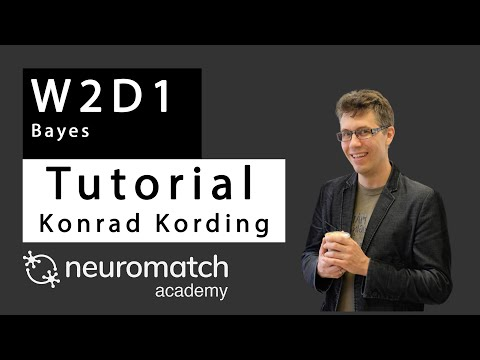

In [11]:
#@title Video 3: Outro
video = YouTubeVideo(id='UgeAtE8xZT8', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

# Summary of Video 3:

There
are now two different modes here if
the
auditory stimulus and the visual stimulus are really quite close to one another, then we have a region where we have linear
integration, where the visual stimulus has a very strong influence on the auditory stimulus.

And then, that's the other mode. If we are far away,
it has very little influence and then there's a relatively steep
transition between these two modes, and this is what's meant with causal inference.

vary the disagreement between cues - measured how one 
influences the other and then they test the
hypothesis that the impact is large if they're close to one another and small if they're far away.
And again, we find this in many domains vision and audition, price and likelihood ,all kinds of cases in cognitive science.

The Bayesian framework allows us to deal with arbitrary probability
distributions.
Gaussians give rise to linear combinations.
Mixture of Gaussians give rise to cause the inference like effects where we have an
interaction that breaks down as soon as the difference is too large. Behavior, then becomes very nonlinear. And
there's a biological principle integration tends to be linear for small difference and
tends to break down for large differences
between cues

In this tutorial, we introduced the ventriloquism setting that will form the basis of Tutorials 3 and 4 as well. We built a mixture-of-Gaussians prior that captures the participants' subjective experiences. In the next tutorials, we will use these to perform causal inference and predict the subject's responses to individual stimuli. 